<a href="https://colab.research.google.com/github/rato42/linear_regression/blob/unstable-yeah-sure/CLASSBASED_new_linear_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports


In [1]:
### comparar modelos usando AIC BIC. talvez trocar pra BIC agora?
### ver como manter legendas do mes legiveis, mas cnosiderar eles como 1 unidade de valor

## no grafico, mudar o nome de previsoes pra sei la slope da regresao linear, tendencia


## ideia, ver o quanto os valores normais ficam distantes da tendencia e comparar com os pandemicos. derivar algum index



####
### TODO: put best_rho in the exported stats

import os
from google.colab import auth
from google.auth import default
from google.colab import drive
from gspread_dataframe import set_with_dataframe
import math
import scipy.stats as stats
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import linregress, ttest_ind, ttest_rel, ttest_1samp
import matplotlib.pyplot as plt
import re
from matplotlib.font_manager import FontProperties
import statsmodels.formula.api as smf
import statsmodels.api as sm

from datetime import datetime, timedelta

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.tools import add_constant

from gspread_dataframe import set_with_dataframe

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer

from dateutil.relativedelta import relativedelta

import logging
from typing import Dict, Any

try:
  import gspread
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install gspread
  import gspread

from googleapiclient.discovery import build
from googleapiclient.http import MediaIoBaseDownload
import io



# LOAD --- data from gsheet


In [2]:
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)



workbook = gc.open_by_url('https://docs.google.com/spreadsheets/d/1m3eEaxWT4Unb8jBZWKjiLivavfA0x3PT1F1Rz1eXwVE/edit?gid=0#gid=0')
worksheets = workbook.worksheets()
output_wksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1RzC3DfKNUwYA-qfUN0i53hUwRkWGMBOCoYQqdqG4MQY/edit?gid=0#gid=0')


# ARGS --- Define Args


In [3]:
ColumnName = 'periodo'
ValueName = 'valores'
DateName = 'date'
VariableName = 'variavel'
SaveArg = True

Args = {
    # data preprocessing
    'PeriodosInclusivos_Range' : [2015,2022], # @[Y1, Y2, M1, M2, D1,D2] start and stop
    'PeriodGrouping' : 1,
    ################### TODO: Need to make a check for multiples of periodgrouping
    'FrequencyDateGroup' : 'QE',
    'ScaleDataValues': True,
    'DatesAsOrdinal' : False,
    'MeltDF': True,

    # regression
    'RegressionMethod': 'prais_winsten', #'ols' or 'prais_winsten'
    'PeriodosExcluirDaRegressao' : [2020,2021],
    'ModelFormula' : ValueName + '~' + ColumnName,
    'IterativeFit': True,
    'MaxIterations': 10,
    'CriterioBestRho' : 'aic', #'aic' or 'bic'

    # prediction
    'additional_dates_factor' : 0.0

    # debug
    #'VerboseResultsAnalysis': True,      ### needs reimplementation

}



# Define Preprocessors


In [4]:
def BuildDataDF(data):
  string_dates = data[0][1:]  # Store original string dates

  # Converter as strings de datas em objetos datetime
  date_list = [datetime.strptime(date, '%d/%m/%Y') for date in string_dates]

  # Extrair os nomes das variáveis
  variavel = [row[0] for row in data[1:]]

  # Extrair os dados (sem agrupamento)
  dados = [row[1:] for row in data[1:]]
  dados = np.array(dados, dtype=int)  # Converter para tipo object para evitar warning

  # Criar o DataFrame with DatetimeIndex
  df = pd.DataFrame(data=dados, index=variavel, columns=pd.DatetimeIndex(date_list))

  return df

class DateFilterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, periodos_inclusivos=None, periodos_exclusivos = None):
        self.periodos_inclusivos = periodos_inclusivos
        self.periodos_exclusivos = periodos_exclusivos

    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self

    def get_date_range(self, Y1, Y2=None, M1=None, M2=None, D1=None, D2=None):
        # Define os valores padrão para mês e dia, se não forem fornecidos
        Y2 = Y2 or Y1
        M1 = M1 or 1
        M2 = M2 or 12
        D1 = D1 or 1
        D2 = D2 or 31  # Considera o último dia do mês como padrão

        # Cria os objetos datetime para o início e fim do intervalo
        start_date = datetime(Y1, M1, D1)
        end_date = datetime(Y2, M2, D2)
        date_range = pd.date_range(start_date, end_date, freq = 'D')
        return date_range

    def transform(self, X):
        # Apply the date filtering logic

        if not isinstance(X.columns[0], pd.Timestamp):
          X.columns = pd.to_datetime(X.columns, format="%Y-%m-%d %H:%M:%S", errors='ignore')

        if self.periodos_inclusivos:
            # Create a mask for exclusive periods
            mask = [col in self.get_date_range(*self.periodos_inclusivos) for col in X.columns]
            X_filtered = X.loc[:, mask]
            return X_filtered
        elif self.periodos_exclusivos:
            # Create a mask for exclusive periods
            mask = [col not in self.get_date_range(*self.periodos_exclusivos) for col in X.columns]
            X_filtered = X.loc[:, mask]
            return X_filtered
        else:
            # If periodos_inclusivos is not provided, return the original DataFrame
            return X




class PeriodGroupingTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer for grouping data by periods (e.g., months, quarters).

    This transformer takes a DataFrame with datetime columns and groups
    the data by specified periods, summing the values within each group.

    Args:
        period_grouping (int): The number of periods to group together.
                               For example, 3 for quarterly grouping.
                               Defaults to 2.
    """
    def __init__(self, period_grouping=2):
        self.period_grouping = period_grouping

    def fit(self, X, y=None):
        """
        This transformer does not require fitting.
        """
        return self

    def transform(self, X):
        """
        Groups the data by specified periods and sums the values.

        Args:
            X (pd.DataFrame): The input DataFrame with datetime columns.

        Returns:
            pd.DataFrame: The grouped DataFrame with summed values.
                          Columns are datetime objects representing the end of each group.
        """
        if self.period_grouping == 1:
          return X
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")

        # Convert columns to datetime if they are not already
        if not isinstance(X.columns[0], pd.Timestamp):
            X.columns = pd.to_datetime(X.columns, errors='coerce')

        grouped_data = {}

        # Iterate over columns, grouping by period_grouping
        for i in range(0, len(X.columns), self.period_grouping):
            group_cols = X.columns[i:i + self.period_grouping]  # Select columns for the current group
            group_name = group_cols[0]  # group_cols[-1] Use the last column's datetime as the group name
            grouped_data[group_name] = X[group_cols].sum(axis=1)  # Sum values within the group

        grouped_df = pd.DataFrame(grouped_data)

        # Ensure columns remain as datetime objects
        grouped_df.columns = pd.to_datetime(grouped_df.columns)

        return grouped_df

In [5]:
class FrequencyGroupingTransformer(BaseEstimator, TransformerMixin):
    """
    ## only datetime supported groupings
    Transformer for grouping data by standard datetime frequencies.

    This transformer takes a DataFrame with datetime columns and groups
    the data by a specified frequency (e.g., 'Q' for quarterly, 'M' for monthly).

    Args:
        frequency (str): The frequency to group by. Defaults to 'Q' (quarterly).
                        Supported frequencies are those accepted by pd.Grouper (e.g., 'Q', 'M', 'Y').
    """
    def __init__(self, frequency='Q'):  # Default to quarterly grouping
        self.frequency = frequency

    def fit(self, X, y=None):
        """
        This transformer does not require fitting.

        Args:
            X (pd.DataFrame): The input DataFrame.
            y (Any, optional): Ignored. Defaults to None.

        Returns:
            self: Returns the transformer instance.
        """
        return self

    def transform(self, X):
        """
        Groups the data by the specified frequency and sums the values.

        Args:
            X (pd.DataFrame): The input DataFrame with datetime columns.

        Returns:
            pd.DataFrame: The grouped DataFrame with summed values.
                          Columns are datetime objects representing the end of each group.
        """
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame.")

        # Convert columns to datetime if they are not already
        if not isinstance(X.columns[0], pd.Timestamp):
            X.columns = pd.to_datetime(X.columns, errors='coerce')

        # Group by the specified frequency using pd.Grouper
        grouped_df = X.T.groupby(pd.Grouper(freq=self.frequency)).sum().T

        return grouped_df

In [6]:
pipe = Pipeline([
    #('scaler', StandardScaler()), ### excluir dpois?
    ('date_filter', DateFilterTransformer(periodos_inclusivos=Args['PeriodosInclusivos_Range'])),
    ('period_grouping', PeriodGroupingTransformer(period_grouping=Args['PeriodGrouping'])),
    #('frequency_grouping', FrequencyGroupingTransformer(frequency=Args['FrequencyDateGroup'])),

])

regression_pipe = Pipeline([
    ('date_filter_exclude', DateFilterTransformer(periodos_inclusivos= None,periodos_exclusivos=Args['PeriodosExcluirDaRegressao'])),
    ('date_filter', DateFilterTransformer(periodos_inclusivos=Args['PeriodosInclusivos_Range'])),
    ('period_grouping', PeriodGroupingTransformer(period_grouping=Args['PeriodGrouping'])),
    #('frequency_grouping', FrequencyGroupingTransformer(frequency=Args['FrequencyDateGroup'])),
    #('date_to_numeric', DateToNumericMapper()),
])


In [7]:
#def generate_periods(df):
  #df[DateName] = df.groupby(VariableName).cumcount() + 1
  #return df

def MeltDF(df, var_name=VariableName, value_name=ValueName, date_name = DateName, y_name = ColumnName):
    # Transpose the DataFrame and reset the index
    df_long = df.T.reset_index()

    # Rename the 'index' column to index_name
    df_long = df_long.rename(columns={'index': date_name})

    # Melt the DataFrame
    df_long = pd.melt(df_long, id_vars=[date_name], var_name=var_name, value_name=value_name)

    # Create a new column for period numbers
    df_long[y_name] = df_long.groupby(var_name).cumcount() + 1


    # Ordenando por categoria e data
    df_final = df_long.sort_values([var_name, date_name]).reset_index(drop=True)

    return df_final

# **EXEC** --- Build DF and Apply Transformers






In [8]:

####
RawDataDF = BuildDataDF(worksheets[0].get_all_values())
RealDataDF = pipe.fit_transform(RawDataDF)
RegressionDataDF = regression_pipe.fit_transform(RawDataDF)


def ordinal_conversion(df):
  ordinal_columns = df.columns.map(lambda x: x.toordinal())
  df.columns = ordinal_columns

  return df

if Args['DatesAsOrdinal']:
  RealDataDF = ordinal_conversion(RealDataDF)
  RegressionDataDF = ordinal_conversion(RegressionDataDF)




In [9]:

MeltedDf = MeltDF(RegressionDataDF)
MeltedDf_real_data = MeltDF(RealDataDF)

# Define Processors


In [10]:
# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


class RegressionProcessor:
	"""
	Performs regression-related operations such as model fitting,
	best rho search, statistics extraction, and retrieving the real series.
	"""
	def __init__(self, args: Dict[str, Any], col_name: str, value_name: str, regression_df : pd.DataFrame):
		self.args = args
		self.col_name = col_name
		self.value_name = value_name
		# The DataFrame from which the "real series" will be obtained.
		#self.real_data_df = real_data_df
		self.regression_df = regression_df

		self.extra_data_storage = {'best_rho': None}

	## called from other internal methods
	def get_variable_df(self, regression_df: pd.DataFrame, variable: str):
		return regression_df[regression_df[VariableName] == variable]

	## filter date for use in the regression itself
	def filter_date(self, df):
		return df

	def model_fit(self, model, iterative_fit: bool = None, max_iterations: int = None, **kwargs):
		"""
		Fits the model using iterative_fit if indicated.
		"""
		if iterative_fit is None:
			iterative_fit = self.args.get('IterativeFit', False)
		if max_iterations is None:
			max_iterations = self.args.get('MaxIterations', 100)
		if iterative_fit:
			if hasattr(model, 'iterative_fit'):
				fit_func = model.iterative_fit
				fit_args = {'maxiter': max_iterations}
			else:
				logger.warning("Model does not support iterative_fit. Using fit() instead.")
				fit_func = model.fit
				fit_args = {}
		else:
			fit_func = model.fit
			fit_args = {}
		return fit_func(**fit_args, **kwargs)

	def find_best_rho(self, df: pd.DataFrame, formula: str, criterio: str = 'aic',
		                  start: float = -1.0, stop: float = 1.01, step: float = 0.05) -> float:
		"""
		Searches for the best rho parameter using the specified criterion.
		"""
		best_rho = 1.0
		best_criterion_value = np.inf
		for rho in np.arange(start, stop, step):
			model = smf.glsar(formula, data=df, rho=rho)
			results = self.model_fit(model)
			criterion_value = getattr(results, criterio)
			if criterion_value < best_criterion_value:
				best_criterion_value = criterion_value
				best_rho = rho
		return best_rho
	def _durbin_watson(self, resid) -> float:
		"""
		Computes Durbin-Watson statistic.
		"""
		from statsmodels.stats.stattools import durbin_watson
		return durbin_watson(resid)

	def get_real_series(self, variable) -> pd.Series:
		"""
		Retrieves the real data series for a variable.
		"""
		return self.get_variable_df(self.regression_df, variable)

	def add_one_month(dt): ### remover
		"""
		Adds one month to a datetime object.

		Args:
			dt: The datetime object to modify.

		Returns:
			A new datetime object with one month added.
		"""
		# Calculate the next month
		try:
			next_month = dt.replace(month=dt.month + 1)
		except ValueError:  # Handle cases like December
			next_month = dt.replace(year=dt.year + 1, month=1)

		return next_month
		##########################
	def extract_result_stats(self, results) -> Dict[str, Any]:
			"""
			Extracts regression parameters and returns them in a dictionary.
			"""
			try:
				r_value = np.sqrt(results.rsquared)
			except (AttributeError, TypeError):
				r_value = np.nan

			try:
				converged = results.converged
			except Exception:
				converged = np.nan

			best_rho = self.extra_data_storage['best_rho']

			slope = results.params.get(self.col_name, np.nan)
			stats_dict = {
				'slope': slope,
				#'slope_normalized': slope / np.mean(serie_values),
				'best_rho' : best_rho,
				'intercept': results.params.get('Intercept', np.nan),
				'p_value': results.pvalues.get(self.col_name, np.nan),
				'std_err': results.bse.get(self.col_name, np.nan),
				'r_value': r_value,
				'r_squared': results.rsquared,
				'r_squared_adj': results.rsquared_adj,
				'Durbin-Watson':  np.round(self._durbin_watson(results.resid), 4),
				'AIC': results.aic,
				'BIC': results.bic,
				'num_obs': results.nobs,
				'fvalue': results.fvalue,
				'f_pvalue': results.f_pvalue,
				'log_likelihood_f': results.llf,
				'condition_number': results.condition_number,
				'df_model': results.df_model,
				'df_resid': results.df_resid,
				'resid': results.resid,
				'bse': results.bse,
				'ssr': results.ssr,
				'centered_tss': results.centered_tss,
				'uncentered_tss': results.uncentered_tss,
				'ess': results.ess,
				'mse_model': results.mse_model,
				'mse_resid': results.mse_resid,
				'mse_total': results.mse_total,
				'tvalues': results.tvalues,
				'pvalues': results.pvalues,
				'converged': converged,
			}
			return stats_dict

	def get_regression_results(self, variable:str): #, date_filter):
		"""
		Returns regression results based on the specified method in args.
		Uses GLSAR with best rho if 'RegressionMethod' is 'prais_winsten', otherwise OLS.
		"""
		method = self.args.get('RegressionMethod', 'ols')
		formula = self.args.get('ModelFormula', '')

		variable_df = self.get_variable_df(self.regression_df, variable)


		if method == 'prais_winsten':
			best_rho = self.find_best_rho(variable_df, formula, criterio=self.args.get('CriterioBestRho', 'aic'))
			self.extra_data_storage['best_rho'] = best_rho
			model = smf.glsar(formula, data=variable_df, rho=best_rho)
			results = self.model_fit(model)
		else:
			model = smf.ols(formula, data=variable_df)
			results = self.model_fit(model)
		return results

	def get_regression_prediction_data(self, variable: str, results_params: any) -> pd.Series:
		"""
		Generates a prediction series for a variable based on the regression results.

		Args:
			variable_df (pd.DataFrame): The DataFrame used to obtain periods (columns).
			results_params: Either a dictionary of regression parameters (with keys 'slope' and 'intercept')
			                or a RegressionResultsWrapper from which these values can be extracted.

		Returns:
			pd.Series: The predicted values with an extended period index.
		"""
		# If results_params is not a dict, try to extract the needed values from its attributes.
		if not isinstance(results_params, dict):
			slope = results_params.params.get(self.col_name, np.nan)
			intercept = results_params.params.get('Intercept', np.nan)
		else:
			slope = results_params.get('slope', np.nan)
			intercept = results_params.get('intercept', np.nan)




		######################### If we change real data to be melted, we need to change this
		# Get periods from RealDataDF
		#periods_ = pd.Series(self.real_data.columns).apply(lambda x: datetime.fromordinal(x)).to_list()
		#periods_ = pd.Index(periods_)
		####
		variable_df = self.get_variable_df(self.regression_df, variable)
		# Get periods from variable_df

		# Extract periods and dates.
		original_periods = variable_df[ColumnName].tolist()
		original_dates = pd.to_datetime(variable_df[DateName]).tolist()

		last_period = original_periods[-1]
		last_date = original_dates[-1]

		# Determine number of additional future points to predict.
		num_additional = int(len(original_periods) * self.args['additional_dates_factor'])

		# Generate future periods and dates.
		additional_periods = [last_period + i for i in range(1, num_additional + 1)]
		additional_dates = [last_date + relativedelta(months=i * self.args['PeriodGrouping']) for i in range(1, num_additional + 1)]

		# Combine original + additional.
		all_periods = original_periods + additional_periods
		all_dates = original_dates + additional_dates

		# Compute predictions using periods.
		predicted_values = [slope * period + intercept for period in all_periods]

		# Build the prediction series with dates as index.
		prediction_series = pd.Series(predicted_values, index=pd.Index(all_dates), name=variable)
		return prediction_series




In [11]:
class SheetExporter:
	"""
	Handles exporting Pandas DataFrames to Google Sheets.
	"""
	def __init__(self, output_wksheet: gspread.Spreadsheet):
		self.output_wksheet = output_wksheet

	def try_create_worksheet(self, title: str) -> None:
		try:
			self.output_wksheet.worksheet(title)
		except gspread.exceptions.WorksheetNotFound:
			self.output_wksheet.add_worksheet(title=title, rows="100", cols="20")
			logger.info(f"Worksheet '{title}' created.")

	def convert_int64_for_json(self, input_df: pd.DataFrame) -> pd.DataFrame:
		df = input_df.copy()
		for column in df.columns:
			if df[column].dtype == 'int64':
				df[column] = df[column].astype(int)
			elif df[column].apply(lambda x: isinstance(x, np.int64)).any():
				df[column] = df[column].apply(lambda x: int(x) if isinstance(x, np.int64) else x)
		return df

	def export_to_sheet(self, df: pd.DataFrame, title: str, include_index: bool = True) -> None:
		clean_df = self.convert_int64_for_json(df)
		self.try_create_worksheet(title)
		ws = self.output_wksheet.worksheet(title)
		ws.clear()
		set_with_dataframe(ws, clean_df, include_index=include_index)
		logger.info(f"DataFrame exported to sheet '{title}'.")



In [12]:
class ResultsDataProcessor:
	"""
	Coordinates the regression processing and exporting.
	It can append regression data from a DataFrame (e.g. RegressionDataDF),
	build exportable DataFrames using configuration, and export to Google Sheets.
	"""
	def __init__(self, args: Dict[str, Any], sheet_exporter: SheetExporter, regression_processor: RegressionProcessor):
		self.args = args

		self.data_dict: Dict[str, Dict[str, Any]] = {}  # per-variable results storage

		self.sheet_exporter = sheet_exporter
		self.regression_processor = regression_processor


		# Configuration for building exportable DataFrames.
		# Keys in export_config refer to DataFrame names that will be built.
		self.export_config: Dict[str, Dict[str, Any]] = {
			'LinearRegressionResultStats': {
				'transform': lambda var, data: pd.DataFrame(data['stats'], index=[var]),
				'include_index': True
			},
			#### TODO: we need to join this wiht variable cfg i guess. Need to pass date filter so i can make multiple regressions with different date filters
			#### TODO: EXPORT THE PERIOD AS WELL?
			'RealDataSeries': {
				'transform': lambda var, data: self.create_serie_df_test(data['real_serie']),
				'include_index': True
			},

      'PredictionSeries': {
        'transform': lambda var, data: self.create_serie_df(data['prediction_serie']),
        'include_index': True
      },

		}
		# Configuration for appending per-variable results.
		# Keys here are produced for each variable and then later used in export.
		self.variable_config: Dict[str, Any] = {

			 ### A dictionary with RegressionWrapper objecs
			'results': lambda var: self.regression_processor.get_regression_results(
        var,
      ),

			'stats': lambda var: self.regression_processor.extract_result_stats(
				self.data_dict[var]['results'],  # ✅ Re-use stored results
			),

			'real_serie': lambda var: self.regression_processor.get_real_series(var),

			'prediction_serie': lambda var: self.regression_processor.get_regression_prediction_data(
				var,
				self.data_dict[var]['results']  # ✅ Re-use stored results
			),
		}


	def process_data(self): ### this hould iterate the self.variable_config, previoulsy was 'append_regression_data_df'

		for variable in self.regression_processor.regression_df[VariableName].unique():
				self.data_dict[variable] = {}
				for key, func in self.variable_config.items():
					self.data_dict[variable][key] = func(variable) ## retrieves a function from the variable_config and executes it in a by variable basis, stores it
				logger.info(f"Processed results for variable '{variable}'.")

	def convert_ordinal_to_datetime(self, df: pd.DataFrame) -> pd.DataFrame:
		"""
		Converts DataFrame columns from numeric date format to datetime.
		Using origin as '1899-12-30' for excel serial dates.
		Returns a new DataFrame with renamed columns.
		"""
		# Check if columns are numeric (likely ordinal)
		if all(isinstance(col, (int, np.integer)) for col in df.columns):
			new_columns = df.columns.map(lambda x: datetime.fromordinal(x))
			renamed_df = df.copy()
			renamed_df.columns = new_columns
			return renamed_df
		else:
			# Columns are not numeric (likely already datetime)
			return df


	### TODO: has to be changed, it now receives a DF (melted). This function should shape the df for sheet exportion
	def create_serie_df(self, serie: pd.Series) -> pd.DataFrame:

		df = pd.DataFrame(serie).T
		df.index = [serie.name]
		return df
	def create_serie_df_test(self, df: pd.DataFrame) -> pd.DataFrame:
		shaped_df = df.pivot(index=VariableName, columns=DateName, values=ValueName)

		# Optional: If you want to have a sorted order on the columns (dates)
		shaped_df = shaped_df.reindex(sorted(shaped_df.columns), axis=1)

		return shaped_df


	def get_exportable_dfs(self) -> Dict[str, pd.DataFrame]:
		"""
		Builds a dictionary of DataFrames ready for export based on export_config.
		"""
		export_dfs: Dict[str, pd.DataFrame] = {}
		for df_name, config in self.export_config.items():
			dfs = []
			for variable, data in self.data_dict.items():
				dfs.append(config['transform'](variable, data))
			export_dfs[df_name] = pd.concat(dfs)

			#if df_name in ['RealDataSeries', 'PredictionSeries']:
				#export_dfs[df_name] = self.convert_ordinal_to_datetime(export_dfs[df_name])

		# Add metadata (if any)
		meta_df = pd.DataFrame(list(self.args.items()), columns=['key', 'value'])
		export_dfs['Metadata'] = meta_df
		return export_dfs

	def process_and_export(self) -> Dict[str, pd.DataFrame]:
		"""
		Processes data into exportable DataFrames and exports them to Google Sheets.
		Returns the dictionary of DataFrames.
		"""
		export_dfs = self.get_exportable_dfs()
		for sheet_title, df in export_dfs.items():
			include_index = self.export_config.get(sheet_title, {}).get('include_index', True)
			self.sheet_exporter.export_to_sheet(df, sheet_title, include_index=include_index)
		return export_dfs

# **EXEC** --- Instantiate Processor and Process/Export

In [13]:
# Instantiate the SheetExporter using your output worksheet
sheet_exporter = SheetExporter(output_wksheet)

# Instantiate the RegressionProcessor with necessary parameters
regression_processor = RegressionProcessor(Args, ColumnName, ValueName, MeltedDf_real_data)

# Instantiate the ResultsDataProcessor; it will coordinate between the modules.
processor = ResultsDataProcessor(Args, sheet_exporter, regression_processor)

# Feed the entire regression data DataFrame into the processor
#processor.append_regression_data_df(RegressionDataDF)
processor.process_data()

# Process data and export it to Google Sheets; also retrieve exportable DataFrames for further analysis.
ExportedDFs = processor.process_and_export()
logger.info("Processing and export completed.")

# Define Hover Graph Func


In [14]:
import plotly.graph_objects as go

def interactive_plot_real_vs_prediction_series(real_df: pd.DataFrame, pred_df: pd.DataFrame,std_err_data = None, highlight_period = '2020'):
  """
  Plots real vs. prediction time series with hover data using Plotly,
  creating separate plots for each variable.
  """
  # Make copies
  real_copy = real_df.copy()
  pred_copy = pred_df.copy()
  # Align shapes by extending the smaller DataFrame
  if pred_copy.shape[1] < real_copy.shape[1]:
  	missing_cols = real_copy.columns.difference(pred_copy.columns)
  	for col in missing_cols:
  		pred_copy[col] = np.nan
  	pred_copy = pred_copy[real_copy.columns]
  elif real_copy.shape[1] < pred_copy.shape[1]:
  	missing_cols = pred_copy.columns.difference(real_copy.columns)
  	for col in missing_cols:
  		real_copy[col] = np.nan
  	real_copy = real_copy[pred_copy.columns]
    # Create separate figures for each variable
  for idx in real_copy.index:
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=real_copy.columns,
        y=real_copy.loc[idx],
        mode='markers',  # use only 'markers' for scatter
        name='Real',
        hovertemplate='<b>%{x}</b><br>Real: %{y:.2f}<extra></extra>'  # Updated hovertemplate
    ))
    # Line plot for prediction data with error bars (if std_err_data is provided)
    if std_err_data is not None and idx in std_err_data:
        fig.add_trace(go.Scatter(
            x=pred_copy.columns,
            y=pred_copy.loc[idx],
            mode='lines+markers',
            name='Prediction',
            hovertemplate='<b>%{x}</b><br>Prediction: %{y:.2f}<extra></extra>',
            error_y=dict(
                type='data',
                array=[std_err_data[idx]] * len(pred_copy.columns),  # Convert to list for error_y
                visible=True,
                thickness=1.5,  # Adjust thickness for visibility
                width=6           # Adjust width for visibility
            )
        ))
    else:
        # If no standard error data, plot without error bars
        fig.add_trace(go.Scatter(
            x=pred_copy.columns,
            y=pred_copy.loc[idx],
            mode='lines+markers',
            name='Prediction',
            hovertemplate='<b>%{x}</b><br>Prediction: %{y:.2f}<extra></extra>'
        ))

    fig.update_layout(
        shapes=[
            dict(
                type="rect",
                xref="x",
                yref="paper",
                x0=real_copy.columns[real_copy.columns.astype(str).str.startswith(highlight_period)][0],
                y0=0,
                x1=real_copy.columns[real_copy.columns.astype(str).str.startswith(highlight_period)][-1],
                y1=1,
                fillcolor="LightSalmon",
                opacity=0.5,
                line_width=0,
                layer="below"
            )
        ]
    )


    fig.update_layout(title=f'Variable: {idx}', xaxis_title='Time', yaxis_title='Value')
    fig.show()
    #fig.update_layout(title=f'Variable: {idx}', xaxis_title='Time', yaxis_title='Value')
    #fig.show()

  return real_copy, pred_copy

# PLOT --- Hover Graph


**TODO:** Verificar a questão da sazonalidade. parece que no inicio do ano sempre há menor registro de atds

**TODO:** talvez fazer a regressao com meses, mas agregar em anos para analisar e demosntrar os resultados

In [15]:
real_copy, pred_copy = interactive_plot_real_vs_prediction_series(ExportedDFs['RealDataSeries'], ExportedDFs['PredictionSeries'], std_err_data = ExportedDFs['LinearRegressionResultStats']['std_err'].to_dict())

# ### Old trash


In [ ]:
def plot_real_vs_prediction_series(real_df: pd.DataFrame, pred_df: pd.DataFrame):
	"""
	Plots real vs. prediction time series for each variable (row).
	Non-destructive: creates internal copies and extends the shorter one with NaNs to match.
	"""
	# Make copies
	real_copy = real_df.copy()
	pred_copy = pred_df.copy()

	# Align shapes by extending the smaller DataFrame
	if pred_copy.shape[1] < real_copy.shape[1]:
		missing_cols = real_copy.columns.difference(pred_copy.columns)
		for col in missing_cols:
			pred_copy[col] = np.nan
		pred_copy = pred_copy[real_copy.columns]
	elif real_copy.shape[1] < pred_copy.shape[1]:
		missing_cols = pred_copy.columns.difference(real_copy.columns)
		for col in missing_cols:
			real_copy[col] = np.nan
		real_copy = real_copy[pred_copy.columns]

	# Plot each variable (row)
	for idx in real_copy.index:
		plt.figure(figsize=(10, 4))
		plt.plot(real_copy.columns, real_copy.loc[idx], label='Real', linestyle='-', marker='o')
		plt.plot(pred_copy.columns, pred_copy.loc[idx], label='Prediction', linestyle='--', marker='x')
		plt.title(f'Variable: {idx}')
		plt.xlabel('Time')
		plt.ylabel('Value')
		plt.legend()
		#plt.grid(True)
		plt.grid(True, which='both', linestyle='--', linewidth=0.5)
		#plt.xticks(real_copy.columns, rotation=45, ha='right')
		plt.tight_layout()
		plt.show()

	return real_copy, pred_copy



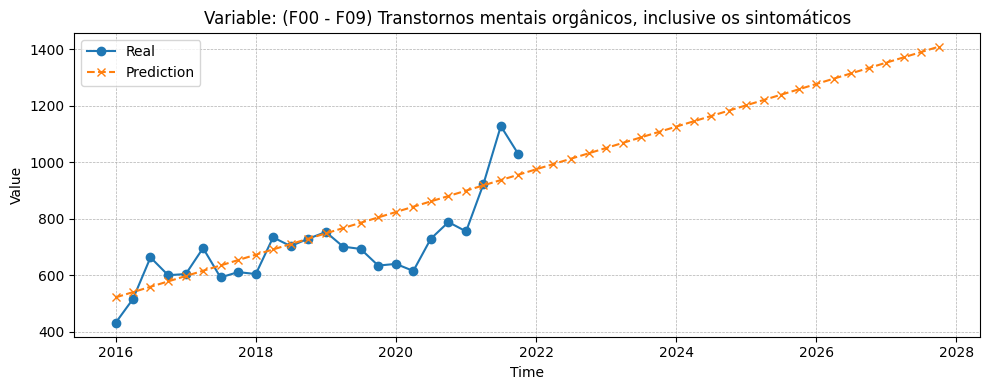

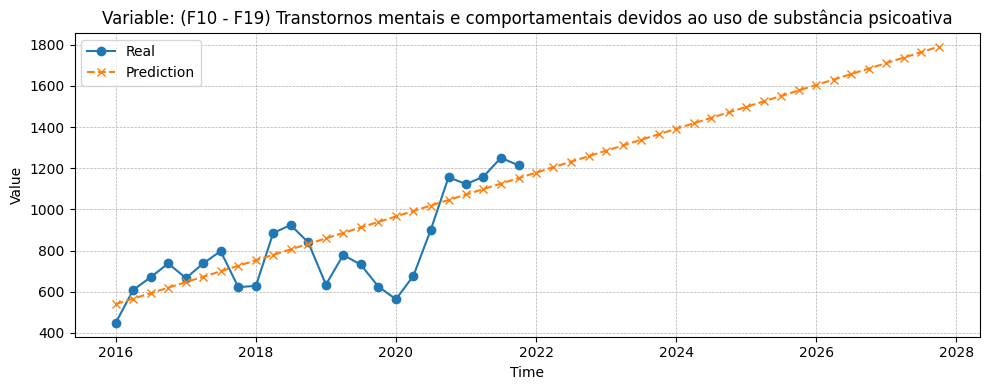

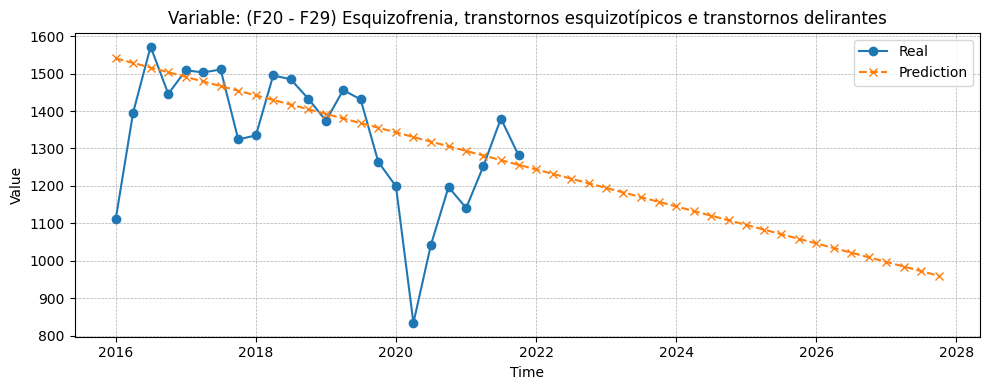

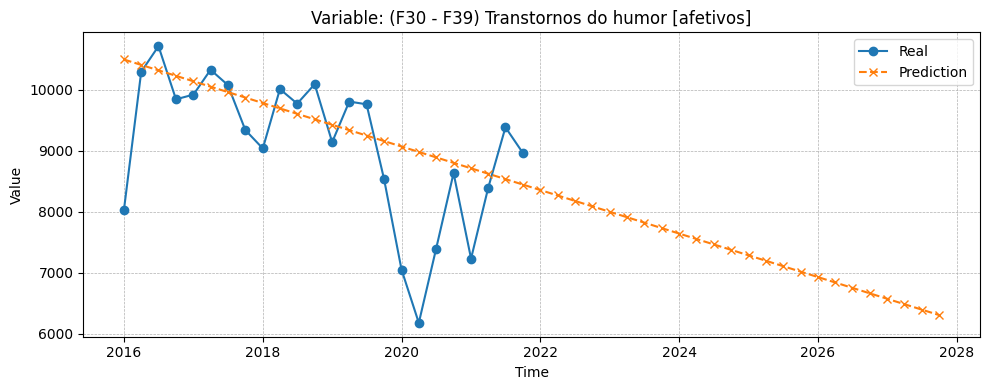

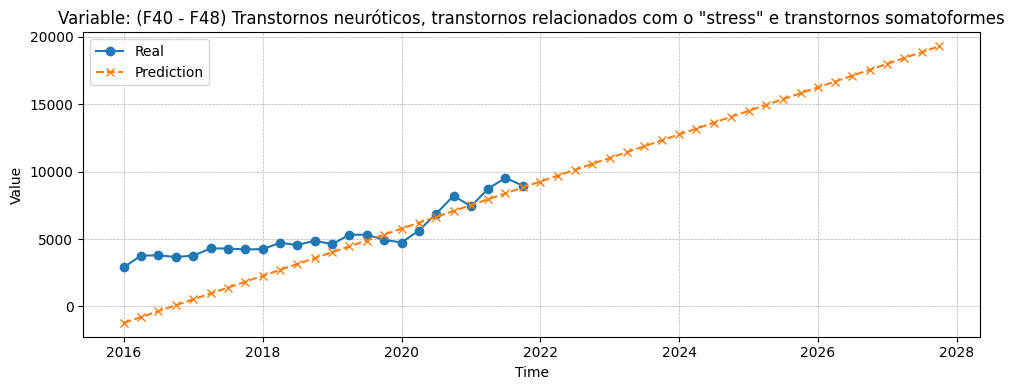

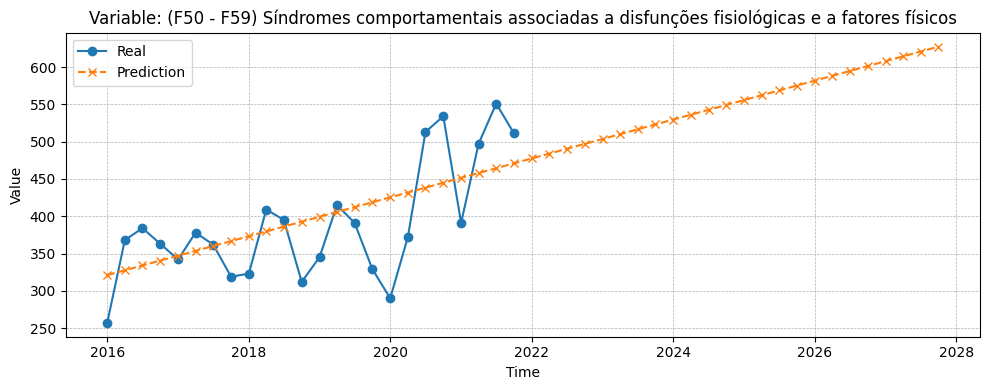

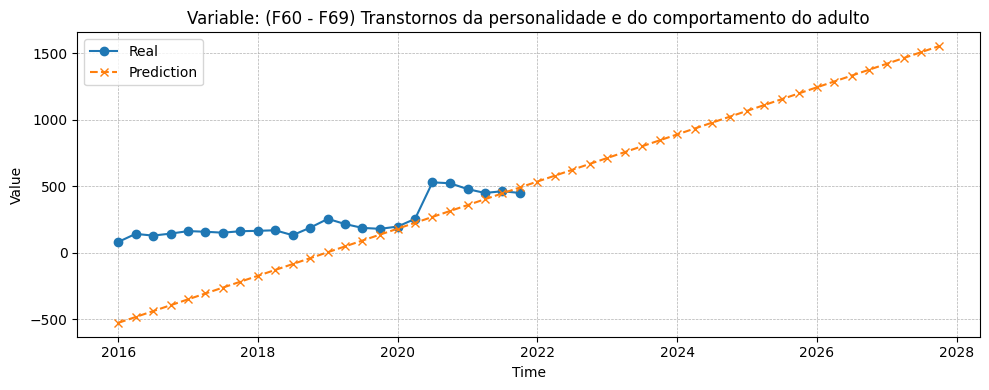

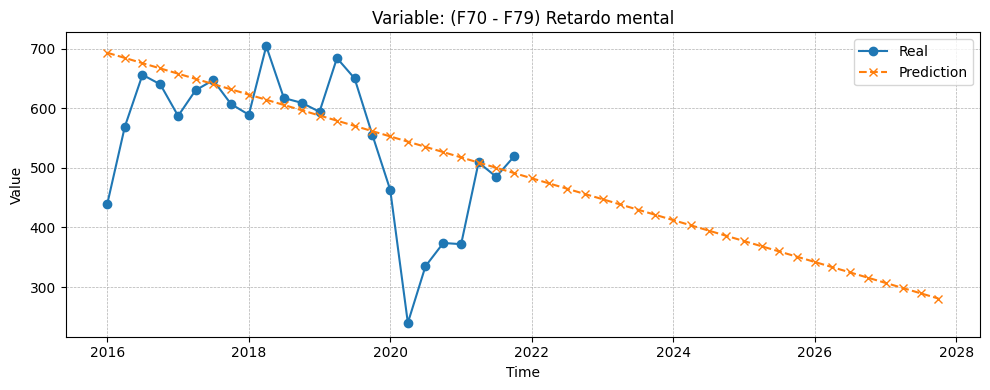

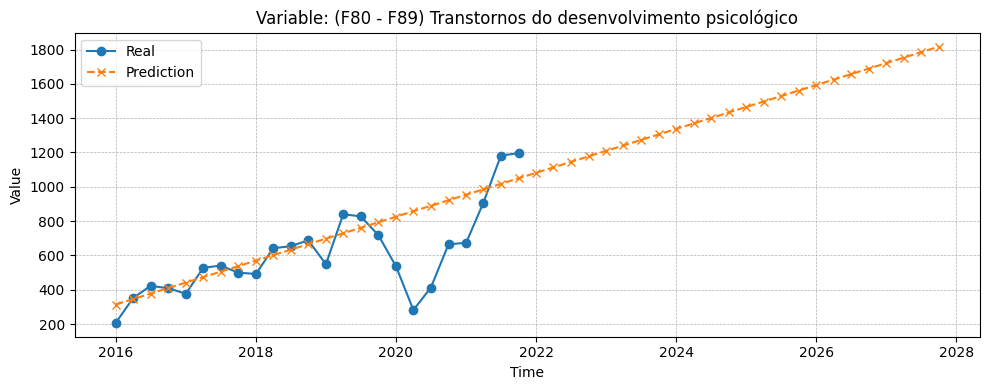

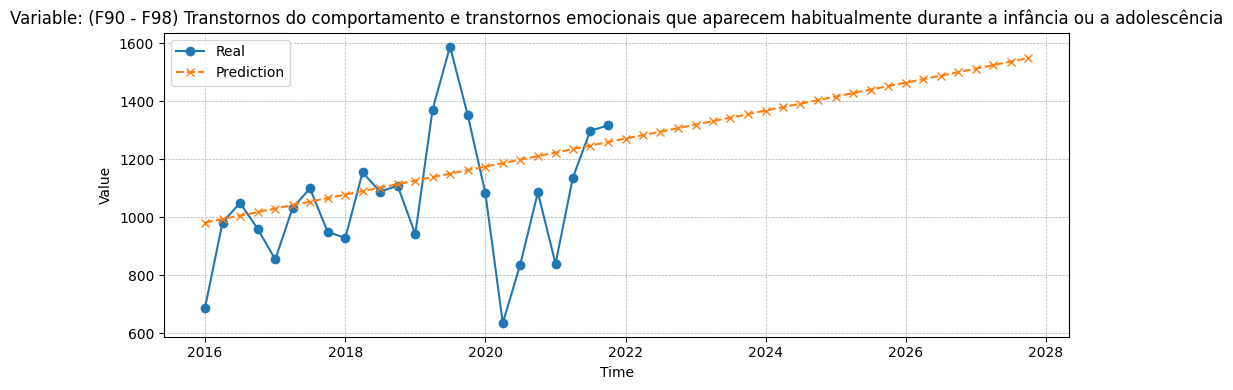

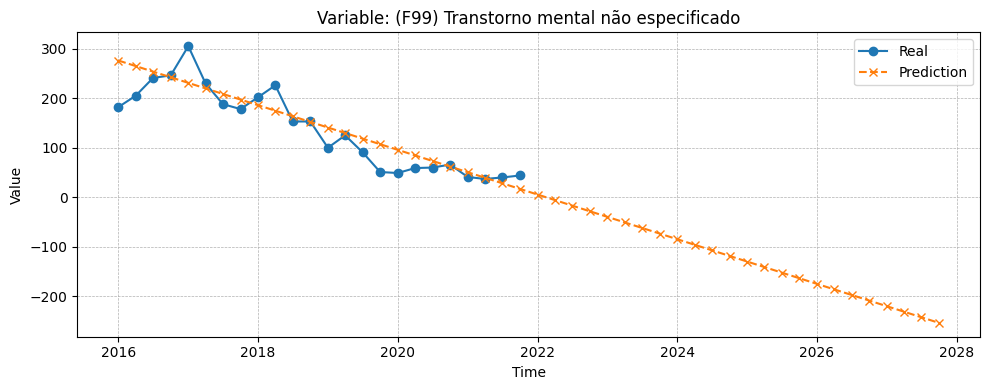

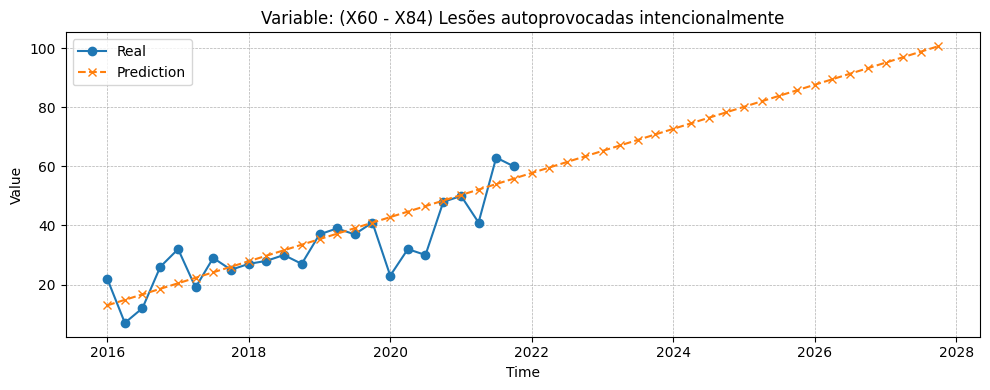

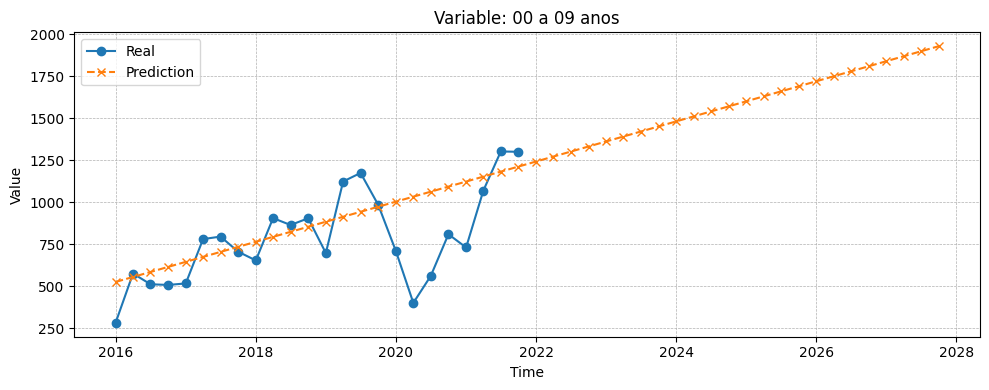

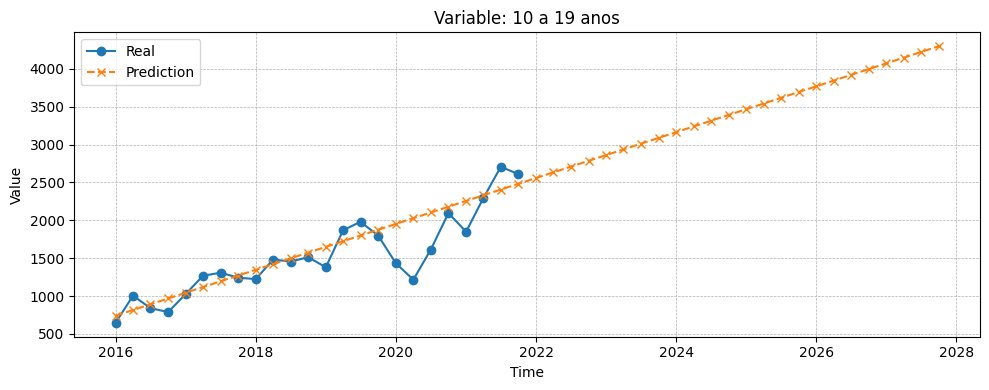

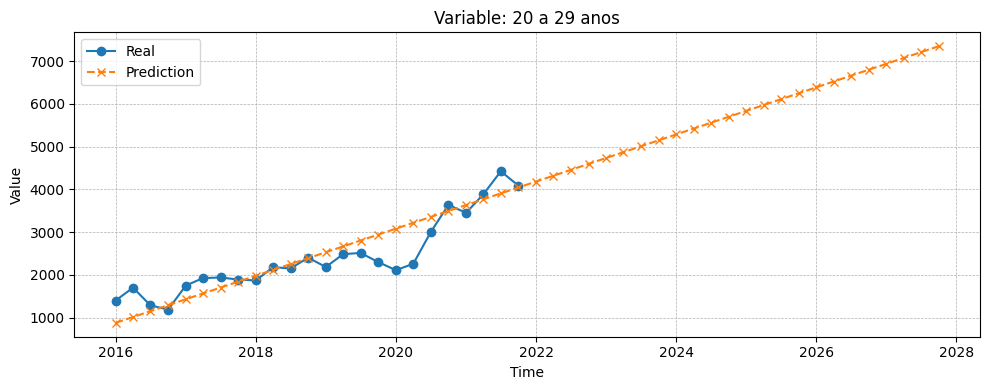

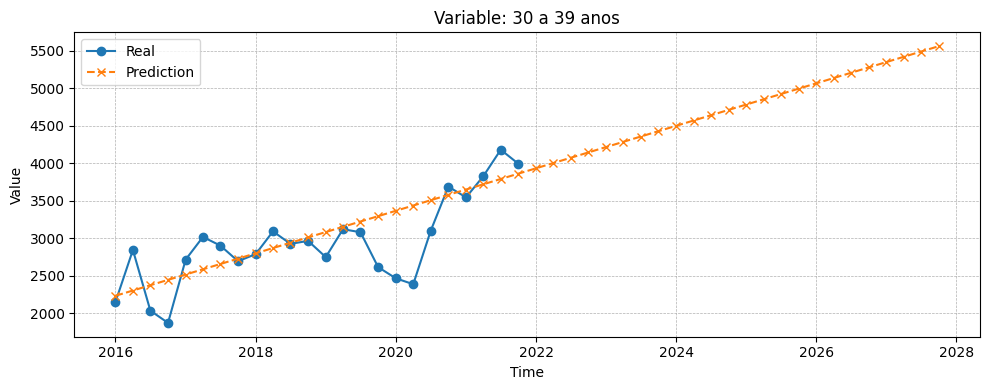

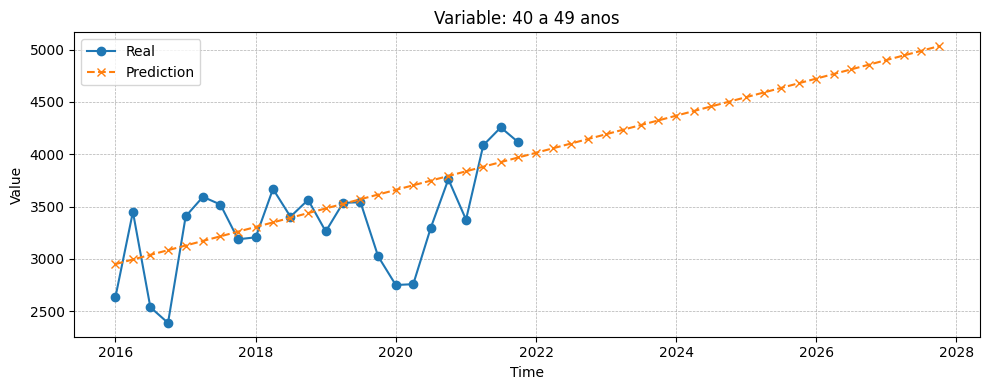

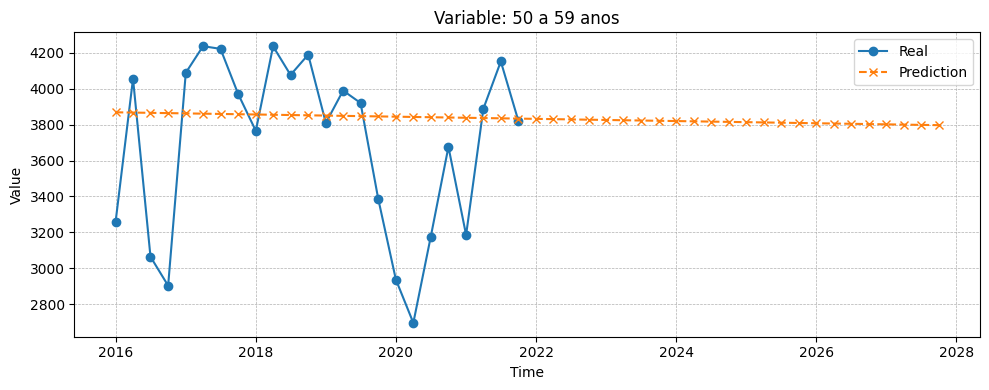

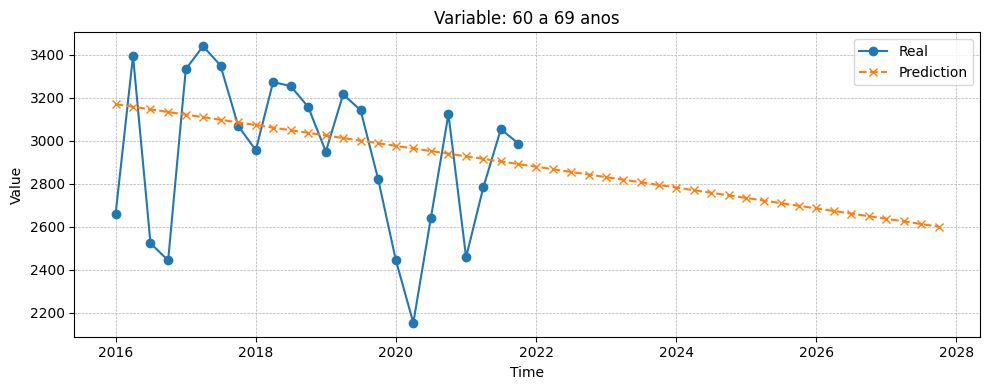

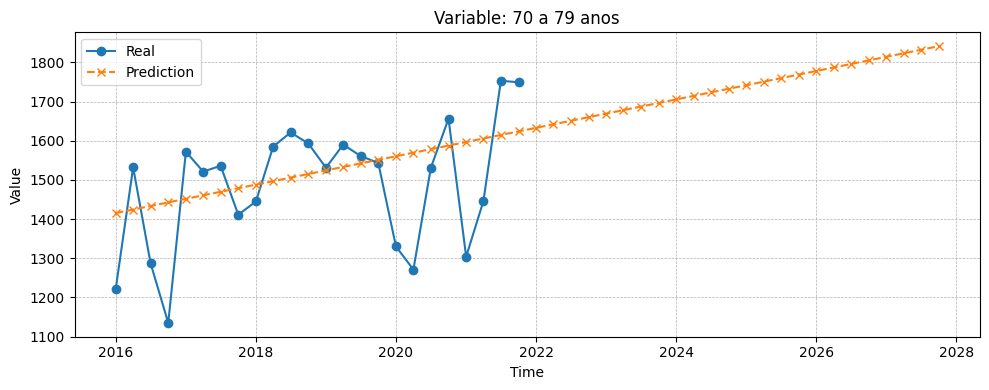

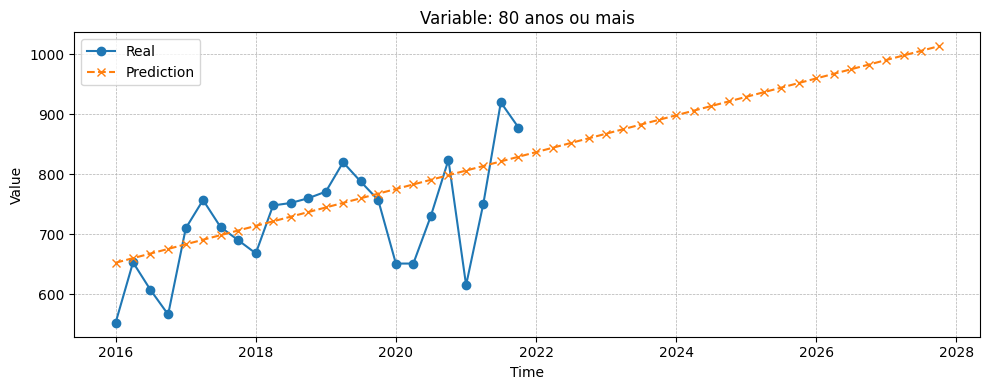

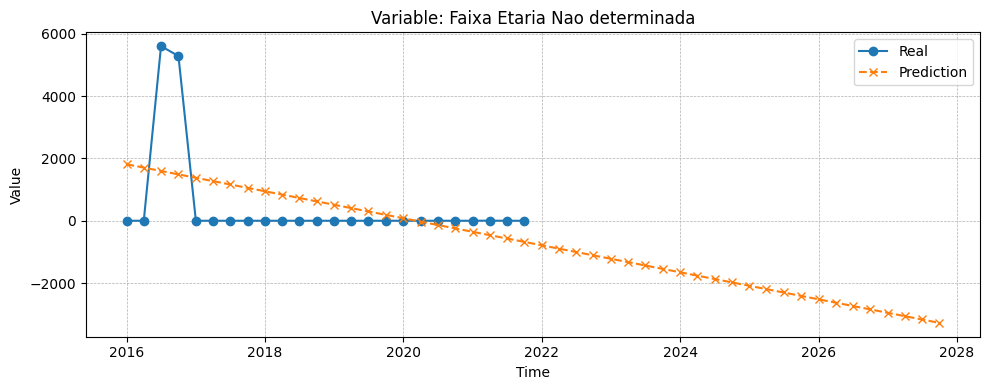

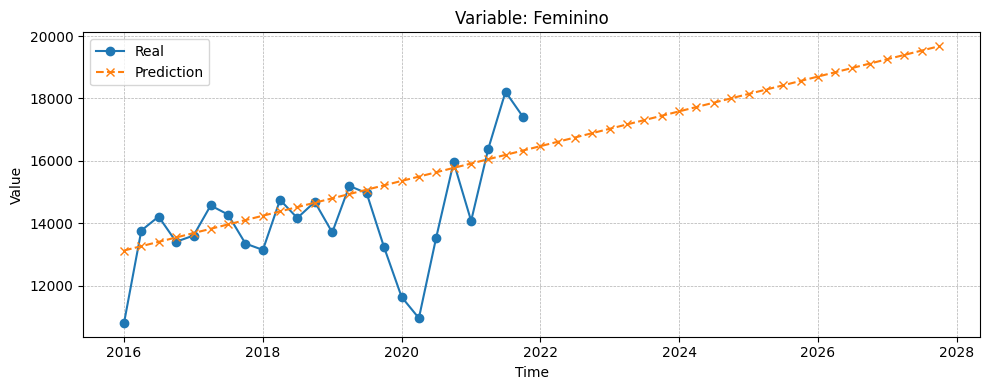

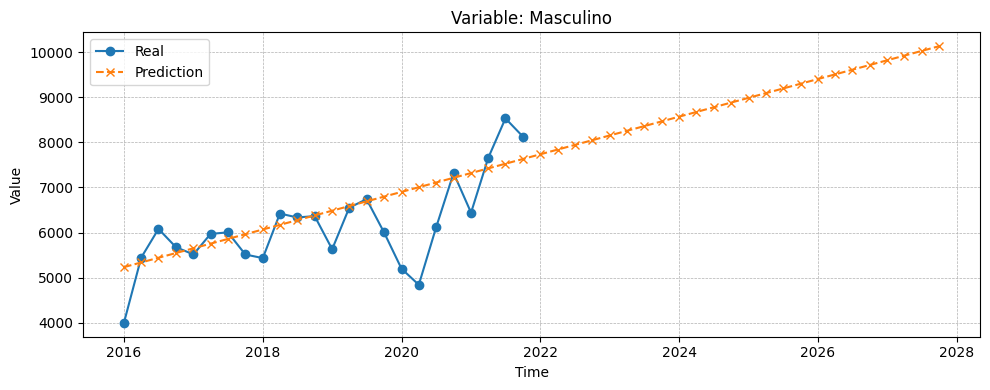

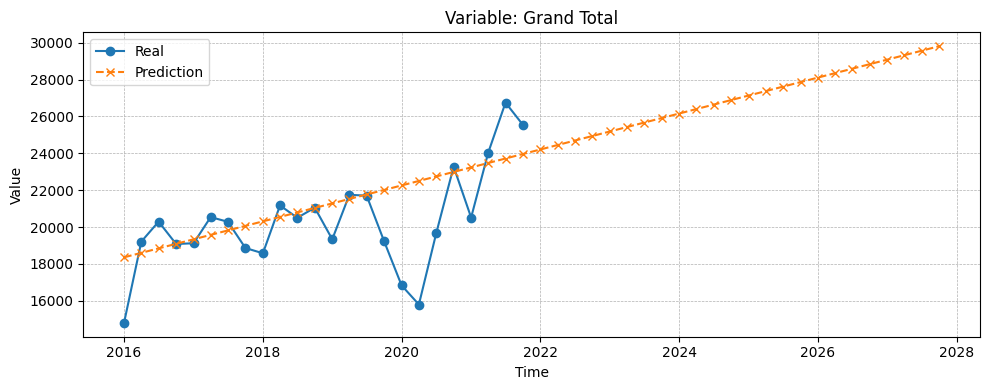

In [ ]:
real_copy, pred_copy = plot_real_vs_prediction_series(ExportedDFs['RealDataSeries'], ExportedDFs['PredictionSeries'])

In [ ]:
### TCR stuff
PeriodosExcluirAnalise = list(set([(period - 1) // Args['PeriodGrouping'] + 1 for period in PeriodosExcluirAnalise_original]))
def CalcSigCI_RealvsPredicted(prediction_data, regression_results_stats, variable_values, lista_anos_de_analise = PeriodosExcluirAnalise, deg_freedom = 1, CI = 0.975):
  CI_data_dict = {}

  standard_error = regression_results_stats['std_err']
  t_value = stats.t.ppf(CI, deg_freedom)
  for ano in lista_anos_de_analise:
    prediction = prediction_data[ano]
    real = variable_values[ano]
    difference = real - prediction
    diff_percent = difference / real

    margin_of_error = t_value * standard_error
    lower_bound = difference - margin_of_error
    upper_bound = difference + margin_of_error

    significant = not (lower_bound <= 0 <= upper_bound)
    p_value_IC = None
    if lower_bound * upper_bound > 0:
        # Não inclui zero no intervalo de confiança
        p_value_IC = 2 * (1 - stats.t.cdf(abs(difference / standard_error), deg_freedom))
    else:
        # Inclui zero no intervalo de confiança
        p_value_IC = stats.t.cdf(abs(difference / standard_error), deg_freedom)

    CI_data_dict[ano] = {
        'real_values': real,
        'prediction_values': prediction,
        'difference': difference,
        'difference_percentual': diff_percent,
        'margin_of_error': margin_of_error,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'significant': significant,
        'p_value_IC': p_value_IC
    }
    if len(lista_anos_de_analise) == 1:
      return CI_data_dict[ano]

  return CI_data_dict

In [ ]:
testa = ['1', '2', '3']
len(testa)
testa_serie = pd.DataFrame(testa)
testa_serie.shape[1]

In [ ]:
df_dados = ExportedDFs['RealDataSeries']
previsoes = ExportedDFs['PredictionSeries']
df_P = ExportedDFs['PredictionSeries']
ResultsStats_DF = ExportedDFs['LinearRegressionResultStats']
#CI_DataDF = CalcSigCI_RealvsPredicted(df_P, ResultsStats_DF, df_dados)
anos_excluir = []#PeriodosExcluirAnalise

toplot_prediction_data = {}
#for index, row in CI_DataDF.iterrows():
  #toplot_prediction_data[index] = {2020: row.to_dict()}

std_errors = ResultsStats_DF['std_err'].to_dict()
slopes_d = ResultsStats_DF['slope'].to_dict()
p_values_d = ResultsStats_DF['p_value'].to_dict()
r_list = ResultsStats_DF['r_value'].to_dict()
r_sqr_list = ResultsStats_DF['r_squared'].to_dict()
r_sqr_adjst_list = ResultsStats_DF['r_squared_adj'].to_dict()
slope_normalized = ResultsStats_DF['slope_normalized'].to_dict()

tipos_transtorno = df_dados.index.tolist()

#anos_adicionais = [2022,2023,2024,2025,2026]
anos = df_dados.columns
anos_adicionais = []#anos[-1] + (len(anos) *2)


anos_adicionais_prev = previsoes.shape[1] #len(anos)-len(PeriodosExcluirAnalise)
#for i in range(anos[-1],anos_adicionais_prev+1):
for i in range(anos_adicionais_prev - len(anos) ,anos_adicionais_prev+1):
  anos_adicionais.append(i)

anos_adicionais = df_dados.columns
######################################################################

escala_constante = False
escala_semi_ajustada = False
sort = True



dados_reais = pd.DataFrame(columns = df_P.columns)

dados_reais[df_dados.columns] = df_dados

previsoes = previsoes.reindex(columns=dados_reais.columns, fill_value=np.nan)








ps = dados_reais.index[0]#dados_reais.iloc[0, 0]  # Primeira linha, primeira coluna
us = dados_reais.index[-1]  # Última linha, primeira coluna


#ps_str = ps.decode('utf-8')  # Convertendo bytes para string usando o encoding 'u

tipo_dado = "INDETERMINADO"
contem_total = us == "Grand Total" or us == "Total"
if ps == "Feminino":
  tipo_dado = "Sexo"
elif ps == "(F20 - F29) Esquizofrenia, transtornos esquizotípicos e transtornos delirantes":
  tipo_dado = "Transtornos_Agrupamento"
elif us == "80 anos ou mais":
  tipo_dado = "Faixa_Etaria"
elif us == "60 anos ou mais":
  tipo_dado = "Faixa_Etaria_Consolidada"
elif re.match(r'^F\d{2,}$', ps):
  tipo_dado = "CID_individual"


if tipo_dado == "Sexo":
  escala_constante = True
  escala_semi_ajustada = False
  sort = False

if tipo_dado == "Faixa_Etaria":
  sort = False

if tipo_dado == "Faixa_Etaria_Consolidada":
  sort = False

fonte = {'fontname': 'DejaVu Serif'}
fonte_legenda = FontProperties(family=fonte['fontname'])

dados_reais_valores = dados_reais.values  # Valores sem cabeçalhos

# Extrair dados de previsões
previsoes_valores = previsoes.values  # Valores sem cabeçalhos

if contem_total:
    dados_reais_valores_calculo = dados_reais_valores[:-1]
    previsoes_valores_calculo = previsoes_valores[:-1]
else:
    dados_reais_valores_calculo = dados_reais_valores
    previsoes_valores_calculo = previsoes_valores

min_value  = np.min(np.concatenate((dados_reais_valores_calculo[:-(anos_adicionais_prev-1)], previsoes_valores_calculo)))
max_value  = np.max(np.concatenate((dados_reais_valores_calculo, previsoes_valores_calculo))) * 1.1

# Definir a magnitude desejada (diminuída em cerca de 5000 unidades)
magnitude = max_value - min_value
magnitude_desejada = magnitude - 8000

# Ajustar o valor mínimo e máximo para ter a magnitude desejada
min_y_total = min_value #- (magnitude - magnitude_desejada) / 2
max_y_total = max_value #+ (magnitude - magnitude_desejada) / 2

total_tipos = len(tipos_transtorno)


# Definir o número de colunas e linhas
num_colunas = 2 if total_tipos == 4 else 3
num_linhas = max(2,(total_tipos + num_colunas - 1) // num_colunas)

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(5*num_colunas, 5 * num_linhas))
plt.subplots_adjust(hspace=1)



max_values_dados_reais = dados_reais.max(axis=1)
max_values_previsoes = previsoes.max(axis=1)

if sort:
  # Combine the maximum values and indices into a single DataFrame
  combined_max_df = pd.DataFrame({'dados_reais_max': dados_reais.max(axis=1), 'previsoes_max': previsoes.max(axis=1)})

  # Sort the combined DataFrame by the maximum values column
  combined_max_df_sorted = combined_max_df.sort_values(by='dados_reais_max', ascending=True)

  # Use the sorted indices to sort both original DataFrames
  dados_reais = dados_reais.loc[combined_max_df_sorted.index]
  previsoes = previsoes.loc[combined_max_df_sorted.index]

  dados_reais_valores = dados_reais.values  # Valores sem cabeçalhos
  previsoes_valores = previsoes.values  # Valores sem cabeçalhos

cabecalhos = dados_reais.columns.tolist()  # Ignorar o cabeçalho da primeira coluna
tipos_transtorno = dados_reais.index.tolist()  # Índices do DataFrame são os tipos de transtorno

def quebrar_titulo(titulo):
    palavras = titulo.split()
    linhas = []
    linha_atual = ""
    for palavra in palavras:
        if len(linha_atual) + len(palavra) <= 30:  # Adiciona a palavra à linha atual se não exceder o limite
            if linha_atual:
                linha_atual += " "
            linha_atual += palavra
        else:  # Se exceder o limite, inicia uma nova linha
            linhas.append(linha_atual)
            linha_atual = palavra
    if linha_atual:
        linhas.append(linha_atual)
    return '\n'.join(linhas)

def check_intersection(bbox1, bbox2):
    x1, y1, width1, height1 = bbox1.bounds
    x2, y2, width2, height2 = bbox2.bounds

    if (x1 < x2 + width2 and x1 + width1 > x2 and
        y1 < y2 + height2 and y1 + height1 > y2):
        return True  # As caixas se intersectam
    else:
        return False  # As caixas não se intersectam


def check_intersection_p(bbox, x_point, y_point):
    # Verificar se a caixa de anotação intersecta o ponto específico
    if bbox.x0 < x_point < bbox.x1 and bbox.y0 < y_point < bbox.y1:
        return True
    else:
        return False

def annotate(ax,x_anno, y_mid, offset):
  ax.annotate(f"Significativo\nDiff: {diff_rounded}\nDiff %: {diff_percent_rounded}",
                                        xy=(x_anno, y_mid), xycoords='data',
                                        xytext=offset, textcoords='offset points',
                                        arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
                                        fontsize= 8.5, bbox=dict(facecolor='lightblue', alpha=0.4))



if False:#total_tipos == 2:
    tipo1, tipo2 = tipos_transtorno

    # Plotar gráfico com duas séries juntas
    figsize = (5, 3) if tipo_dado == "Faixa_Etaria_Consolidada" else (10,6)
    plt.figure(figsize=figsize)
    plt.plot(cabecalhos, dados_reais_valores[0], label=tipo1 + ' (Dados Reais)', marker='o')
    plt.errorbar(cabecalhos,previsoes_valores[0], yerr=std_errors[tipo1], label=tipo1 + ' (Previsões)', linestyle="--", capsize = 10)
    #plt.plot(cabecalhos, previsoes_valores[0], label=tipo1 + ' (Previsões)', marker='o', linestyle= "--")
    plt.plot(cabecalhos, dados_reais_valores[1], label=tipo2 + ' (Dados Reais)', marker='x',  **fonte)
    #plt.plot(cabecalhos, previsoes_valores[1], label=tipo2 + ' (Previsões)', marker='x', linestyle= "--")
    plt.errorbar(cabecalhos,previsoes_valores[1], yerr=std_errors[tipo2], label=tipo2 + ' (Previsões)', linestyle="--", capsize = 10)
    h_ali = 0.01
    for i, (tipo, dados_reais, previsoes, p_val) in enumerate(zip(tipos_transtorno, dados_reais_valores, previsoes_valores, p_values_d)):
            p_val = p_values_d[tipo]
            # Verifique se o p-value é menor que 0.05
            if p_val < 0.05:
                # Se sim, defina o peso da fonte como "bold"
                fontweight = 'bold'
                fontstyle = "normal"
            elif p_val < 0.1:
                fontweight = 'normal'
                fontstyle = "italic"
            else:
                # Se não, mantenha o peso da fonte normal
                fontweight = 'normal'
                fontstyle = "normal"

            # Crie as strings para os textos
            text_labels = [
                "Regressão Linear",
                tipo,
                "Erro Padrão (±): {:.2f}".format(std_errors[tipo]),
                "Coef. Angular (β₁): {:.2f} ".format(slopes_d[tipo]),
                "p-Value: {:.4f}".format(p_val),
                "Coef. Correlação (r): {:.3f}".format(r_list[tipo]),
                #"Coef. Determinação (r²): {:.3f}".format(r_sqr_list[tipo])
            ]

            if r_sqr_adjst_list[tipo]:
              text_labels.append("Coef. Determinação Ajustado (r²): {:.3f}".format(r_sqr_adjst_list[tipo]))
            else:
              text_labels.append("Coef. Determinação (r²): {:.3f}".format(r_sqr_list[tipo]))
            # Adicione os textos ao gráfico
            v_ali = -0.12

            for i, text_label in enumerate(text_labels):
                plt.text(h_ali, v_ali- i*0.05, text_label, fontsize=8, fontweight= i == 3 and fontweight or 'normal', **fonte, fontstyle = i == 3 and fontstyle or "normal", horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes)
            h_ali = h_ali +0.3



    plt.xlabel('Ano')
    plt.ylabel('Valores')
    plt.title(tipo_dado)
    plt.legend()
    plt.grid(True)
    plt.savefig(f"{tipo_dado}_graficos_agrupados.pdf", format='pdf')
    plt.savefig(f"{tipo_dado}_graficos_agrupados.svg", format='svg')
    plt.show()
else:
# Criar gráficos para cada tipo de transtorno
  for i, tipo in enumerate(dados_reais.index):


      serie_dados_reais = dados_reais.loc[tipo].values
      serie_previsoes = previsoes.loc[tipo].values


      linha = i // num_colunas
      coluna = i % num_colunas

      min_serie = np.min(np.minimum(serie_dados_reais, serie_previsoes))
      max_serie = np.max(np.maximum(serie_dados_reais, serie_previsoes))

      # Verificar se a série atual tem um valor máximo menor que 500
      if escala_semi_ajustada:
        if max_serie < 100:
          min_y = min(min_serie-(min_serie*0.05),0)
          max_y = 110
        elif max_serie < 300:
          min_y = min(min_serie-(min_serie*0.05),100)
          max_y = 330
        elif max_serie < 500:
          min_y = min(min_serie-(min_serie*0.05),100)
          max_y = 550
        elif max_serie < 2000:
          min_y = min(min_serie-(min_serie*0.05),500)
          max_y = 2200
        elif max_serie < 3000:
          min_y = min(min_serie-(min_serie*0.05),500)
          max_y = 3300
        elif max_serie < 6200:
          min_y = min(min_serie-(min_serie*0.05),1000)
          max_y = 6200*1.1
        elif max_serie < 10000:
          min_y = min(min_serie-(min_serie*0.05),1000)
          max_y = 11000
        elif max_serie < 16000:
          min_y = min(min_serie-(min_serie*0.05),1000)
          max_y = 16000*1.1
        elif max_serie < 22000:
          min_y = min(min_serie-(min_serie*0.05),1000)
          max_y = 22000*1.1
        elif max_serie < 30000:
          min_y = min(min_serie-(min_serie*0.05),1000)
          max_y = 30000 *1.1
        elif max_serie < 55000:
          min_y = 10000 if tipo_dado != "Faixa_Etaria" else min(min_serie-(min_serie*0.05), 10000)
          max_y = 56000
        else:
          min_y = min_serie *0.9#min(np.minimum(serie_dados_reais, serie_previsoes)) *0.9
          max_y = max_serie *1.1
      #elif tipo_dado == "Sexo":
        #min_y = 34000
        #max_y - 81000
      elif escala_constante:

          if escala_semi_ajustada and max_serie < 10000:
              escala_info = '_escala_semi_ajustada_LOW'
              # Se sim, ajustar os limites dos eixos y para a série atual
              min_y = min(min_serie,-500)#min_y_total
              max_y = min(max(max_serie*1.1, 3000), 6500)##max_y_total*0.33   # Ajustando para ser 10% maior que o valor máximo
          elif escala_semi_ajustada and max_serie < 1000:
              escala_info = '_escala_semi_ajustada_Extremo_LOW'
              min_y = min(min_serie,-100)
              max_y = 1000
          elif tipo == "Total" or tipo == "Grand Total" and contem_total:
            if escala_semi_ajustada:
              escala_info = '_escala_semi_ajustada_TOTAL'
              min_y = min_serie *0.95#min(np.minimum(serie_dados_reais, serie_previsoes)) *0.9
              max_y = max_serie *1.05#max(np.maximum(serie_dados_reais, serie_previsoes)) *1.1
            else:
              escala_info = '_escala_ajustada_TOTAL'
              min_y = np.min(np.concatenate((dados_reais_valores, previsoes_valores)))
              max_y = np.max(np.concatenate((dados_reais_valores, previsoes_valores))) * 1.1
          else:
            if escala_semi_ajustada:
              escala_info = '_escala_semi_ajustada_LOW'
              min_y = min(min_serie * 0.9, 14000)#min_y_total
              max_y = min(max_serie *1.1, max_y_total)
            else:
              escala_info = '_escala_constante'
              # Caso contrário, aplicar os limites calculados para o intervalo total

              min_y = min_y_total
              max_y = max_y_total
      else:
          escala_info = 'escala_variavel'
          min_y = min(np.minimum(serie_dados_reais, serie_previsoes))
          max_y = max(np.maximum(serie_dados_reais, serie_previsoes)) * 1.1

      titulo_quebrado = quebrar_titulo(tipo)



      axs[linha, coluna].plot(cabecalhos, serie_dados_reais, label='Dados Reais', marker='o', color = "black", markersize = 4)

      prev_label = "Previsões" if anos_adicionais_prev > 0 else "Dados Esperados"
      color_prev = "green" if anos_adicionais_prev > 0 else "orange"
      axs[linha, coluna].errorbar(cabecalhos, serie_previsoes, yerr=std_errors[tipo], label=prev_label, color =color_prev,  linestyle="--",  capsize = 5)
      upper_bound = [previsao + std_errors[tipo] for previsao in serie_previsoes]
      lower_bound = [previsao - std_errors[tipo] for previsao in serie_previsoes]


      color_pand = "blue"
      anos = [int(ano) for ano in cabecalhos]

      indices_anos = [cabecalhos.index(ano) for ano in anos_excluir if ano in cabecalhos]

      # Use os índices para plotar uma única linha para todos os anos

      axs[linha, coluna].errorbar([cabecalhos[indice] for indice in indices_anos],
                                  [serie_previsoes[indice] for indice in indices_anos],
                                  yerr=[std_errors[tipo] for indice in indices_anos],
                                  label="Dados Esperados (Pandemia)",
                                  marker='o',
                                  color=color_pand,
                                  linestyle="",
                                  capsize=5, markersize=6)
      '''
      axs[linha, coluna].plot([cabecalhos[indice] for indice in indices_anos],
                                  [serie_previsoes[indice] for indice in indices_anos],
                                  label="Dados Esperados (Pandemia)",
                                  marker='o',
                                  color=color_pand,
                                  linestyle="",
                                  markersize = 6)

      '''

      p_val = p_values_d[tipo]

      # Verifique se o p-value é menor que 0.05
      if p_val < 0.05:
          # Se sim, defina o peso da fonte como "bold"
          fontweight = 'bold'
          fontstyle = "normal"
      elif p_val < 0.1:
          fontweight = 'normal'
          fontstyle = "italic"
      else:
          # Se não, mantenha o peso da fonte normal
          fontweight = 'normal'
          fontstyle = "normal"

      # Crie as strings para os textos
      l_std_error = "Erro Padrão (±): {:.2f}".format(std_errors[tipo])  # Formata o erro padrão com duas casas decimais
      l_slope = "Coef. Angular (β₁): {:.2f}".format(slopes_d[tipo])  # Formata o coeficiente angular com duas casas decimais
      l_slope_normal = "Tx. Cresc. Rel. à Média: {:.2f}%".format(slope_normalized[tipo]*100)
      l_PV = "p-Value: {:.5f}".format(p_val)   # Formata o p-value com quatro casas decimais
      l_r = "Coef. Correlação (r): {:.3f}".format(r_list[tipo])
      #l_r_sqr = "Coef. Determinação (r²): {:.3f}".format(r_sqr_list[tipo])


      if r_sqr_adjst_list[tipo]:
              l_r_sqr = "Coef. Determinação Ajustado (r²): {:.3f}".format(r_sqr_adjst_list[tipo])
      else:
              l_r_sqr = "Coef. Determinação (r²): {:.3f}".format(r_sqr_list[tipo])
            # Adicione os textos ao gráfico

      # Adicione os textos ao subplot com o peso da fonte correspondente
      axs[linha, coluna].text(0.02, -0.12, "Regressão Linear", fontsize=9, fontweight='normal', horizontalalignment='left', verticalalignment='center', transform=axs[linha, coluna].transAxes, **fonte)
      axs[linha, coluna].text(-0.1, -0.17, l_std_error, fontsize=9, fontweight='normal', horizontalalignment='left', verticalalignment='center', transform=axs[linha, coluna].transAxes, **fonte)
      axs[linha, coluna].text(-0.1, -0.22, l_slope, fontsize=9, fontweight='normal', horizontalalignment='left', verticalalignment='center', transform=axs[linha, coluna].transAxes, **fonte)
      axs[linha, coluna].text(-0.1, -0.27, l_slope_normal, fontsize=9, fontweight='normal', horizontalalignment='left', verticalalignment='center', transform=axs[linha, coluna].transAxes, **fonte)

      #axs[linha, coluna].text(0.00, -0.27, l_PV, fontsize=9, fontweight=fontweight, fontstyle = fontstyle, horizontalalignment='left', verticalalignment='center', transform=axs[linha, coluna].transAxes, **fonte)
      #axs[linha, coluna].text(0.00, -0.32, l_r, fontsize=9,  fontweight='normal', horizontalalignment='left', verticalalignment='center', transform=axs[linha, coluna].transAxes, **fonte)
      #axs[linha, coluna].text(0.00, -0.37, l_r_sqr, fontsize=9,  fontweight='normal', horizontalalignment='left', verticalalignment='center', transform=axs[linha, coluna].transAxes, **fonte)


      axs[linha, coluna].text(0.55, -0.17, l_PV, fontsize=9, fontweight=fontweight, fontstyle = fontstyle, horizontalalignment='left', verticalalignment='center', transform=axs[linha, coluna].transAxes, **fonte)
      axs[linha, coluna].text(0.55, -0.22, l_r, fontsize=9,  fontweight='normal', horizontalalignment='left', verticalalignment='center', transform=axs[linha, coluna].transAxes, **fonte)
      axs[linha, coluna].text(0.55, -0.27, l_r_sqr, fontsize=9,  fontweight='normal', horizontalalignment='left', verticalalignment='center', transform=axs[linha, coluna].transAxes, **fonte)
     # axs[linha, coluna].set_aspect('auto')

      if len(anos_excluir) == 1:  # Caso apenas um ano seja especificado
                      ano_especifico = anos_excluir[0]
                      if ano_especifico in cabecalhos:  # Verifica se o ano está presente nos cabeçalhos
                          indice_ano = cabecalhos.index(ano_especifico)
                          axs[linha, coluna].axvspan(cabecalhos[indice_ano] - 0.5, cabecalhos[indice_ano] + 0.5, ymin=0, ymax=1, color="lightblue", alpha=0.3, zorder=-1)



      #axs[linha, coluna].set_yscale("log")
      axs[linha, coluna].set_xlabel('Ano',**fonte)
      '''
      if anos_adicionais_prev > 0:
        x_labels = axs[linha, coluna].get_xticklabels()
        #print(x_labels)
        x_labels_int = [int(float(label.get_text())) for label in x_labels]
        #print(x_labels)
        axs[linha, coluna].set_xticklabels(x_labels_int)
      '''
      axs[linha, coluna].set_ylabel('Nº de Atendimentos', **fonte)
      axs[linha, coluna].set_title(titulo_quebrado, fontsize=10, **fonte)
      axs[linha, coluna].legend(prop = fonte_legenda)
      axs[linha, coluna].grid(True)

      legenda_pos = plt.gca().get_legend()


      analise = None#toplot_prediction_data[tipo]




      try:
        for i, (ano_analise, info) in enumerate(analise.items()):
              indice_ano = cabecalhos.index(ano_analise)

              # Calcula a altura total da escala do eixo y
              y_scale_size = max_y - min_y
              y_anterior = serie_dados_reais[indice_ano - 1]
              y_ultima_prev = serie_previsoes[len(serie_previsoes)-1]

              # Use o índice do ano para encontrar a posição correspondente na série de previsões
              x_anno = cabecalhos[indice_ano]  # A coordenada x para a anotação é o ano analisado
              y_anno = serie_dados_reais[indice_ano]  # A coordenada y para a anotação é o valor da previsão para o ano analisado
              y_prev = serie_previsoes[indice_ano]
              y_mid = (y_anno + y_prev)/2

              posicao_y_anotacao = ( y_mid- min_y) / (y_scale_size)
              posicao_y_anterior = ( y_anterior- min_y) / (y_scale_size)
              posicao_y_ultima_prev = ( y_ultima_prev- min_y) / (y_scale_size)

              posicao_threshold = 0.6
              axs[linha, coluna].annotate('', xy=(x_anno, y_prev), xytext=(x_anno, y_anno),
              arrowprops=dict(arrowstyle='<|-|>', color="black", alpha =0.5, mutation_scale = 15))

              #print(tipo, legenda_pos, posicao_y_anotacao, slopes_d[tipo])
              if posicao_y_anotacao > 0.4:
                if slopes_d[tipo] > 0:
                  x_offset = 60
                  y_offset = -60
                else:
                  x_offset = 60
                  y_offset = 60 if legenda_pos == "upper" else -80
              else:
                if posicao_y_ultima_prev < 0.4:
                  x_offset = -100 if slopes_d[tipo] > 0 else 40
                  y_offset = 40
                elif slopes_d[tipo] > 0:
                  x_offset = 60
                  y_offset = -30
                else:
                  x_offset = 60
                  y_offset = 50

              # Arredonde os valores de diferença e diferença percentual
              diff_rounded = round(info['difference'], 2)  # Arredonda para 2 casas decimais
              diff_percent_rounded = round(info['difference_percentual']*100, 2)  # Arredonda para 2 casas decimais
              p_value_anal = "p-Value: {:.5f}".format(info["p_value_IC"])

              # Adicione a anotação ao subplot

              offset = (x_offset, y_offset)
              text_sign = "IC Significativo\n" if info["significant"] else "IC Não Significativo\n"
              an_text =f"{text_sign}{p_value_anal}\nΔ: {diff_rounded} ({diff_percent_rounded} %)"

              face_color = "lightblue" if info["significant"] else "gray"
              font_weight ="normal" #'bold' if info["sgnf"] else 'normal'
              fontsize = 8.5 if info["significant"] else 8.5
              annotation = axs[linha, coluna].annotate(an_text,
                                                      xy=(x_anno, y_mid), xycoords='data',
                                                      xytext=offset, textcoords='offset pixels',
                                                      arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=0"),
                                                      fontsize=fontsize, bbox=dict(facecolor=face_color, alpha=0.4),
                                                      fontweight=font_weight, **fonte)
              bbox_current = annotation.get_window_extent(renderer=None)
      except:
        print("sorrrey no can do the thing")

      # Definir os limites dos eixos y para ter a magnitude desejada

      axs[linha, coluna].set_ylim(min_y, max_y)
      axs[linha, coluna].set_xlim(cabecalhos[0], cabecalhos[len(cabecalhos)-1])
      # Salvar o gráfico em PDF
      #plt.savefig(f"{escala_info}_{tipo}_gráfico.pdf", format='pdf')
      #plt.show()
      # Salvar o gráfico em formato editável (SVG)
      #plt.savefig(f"{escala_info}_{tipo}_gráfico.svg", format='svg')

  plt.tight_layout()


  plt.subplots_adjust(hspace=0.7)

  dpi = 1000 if len(tipos_transtorno) < 20 else 1

  if anos_excluir == [] and anos_adicionais_prev > 0:
      plt.savefig(f"previsoes_futuras_anos_completos_{tipo_dado}_graficos_agrupados.pdf", format='pdf', dpi =dpi)
      plt.savefig(f"previsoes_futuras_anos_completos_{tipo_dado}_graficos_agrupados.svg", format='svg',dpi =dpi)
  else:
      plt.savefig(f"{tipo_dado}_graficos_agrupados.pdf", format='pdf',dpi =dpi)
      plt.savefig(f"{tipo_dado}_graficos_agrupados.svg", format='svg',dpi =dpi)

  plt.show()
  print("tipo de dado: ", tipo_dado)

In [ ]:
if False:
  for variable, results in results.items():
        print(f"Regression results for variable: {variable}")
        print(results.summary())
        print("\n")  # Add a separator between variables
